In [1]:
import os
import gc
import glob
import random
import sys
# sys.path.append('../input/iterativestratification')
import pickle
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import date, datetime

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import KFold , StratifiedKFold, GroupKFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MultiLabelBinarizer

from imblearn.under_sampling import RandomUnderSampler

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import Pool
from gensim.models import word2vec
# from tabpfn import TabPFNClassifier
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(0)

In [3]:
train_df = pd.read_csv("/kaggle/input/atmacup-15dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/atmacup-15dataset/test.csv")
anime_df = pd.read_csv("/kaggle/input/atmacup-15dataset/anime.csv")

In [4]:
def create_kfold_seen(df):
    sgk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df["kfold"] = -1
    for i, (tr_id, va_id) in enumerate(sgk.split(df, df["score"].values)):
        df.loc[va_id, "kfold"] = int(i)
    return df

def create_kfold_unseen(df):
    sgk = GroupKFold(n_splits=5)
    df["kfold"] = -1
    for i, (tr_id, va_id) in enumerate(sgk.split(df, df["user_id"], df["user_id"])):
        df.loc[va_id, "kfold"] = int(i)   
    return df


def stratified_and_group_kfold_split(train_df):
    # https://www.guruguru.science/competitions/21/discussions/45ffc8a1-e37c-4b95-aac4-c4e338aa6a9b/

    # 20%のユーザを抽出
    n_user = train_df["user_id"].nunique()
    unseen_users = random.sample(sorted(train_df["user_id"].unique()), k=n_user // 5)
    train_df["unseen_user"] = train_df["user_id"].isin(unseen_users)
    unseen_df = train_df[train_df["unseen_user"]].reset_index(drop=True)
    train_df = train_df[~train_df["unseen_user"]].reset_index(drop=True)

    # train_dfの80%をStratifiedKFoldで分割
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold_id, (_, valid_idx) in enumerate(skf.split(train_df, train_df["user_id"])):
        train_df.loc[valid_idx, "fold"] = fold_id

    # 20%をGroupKFoldで分割
    gkf = GroupKFold(n_splits=5)
    unseen_df["fold"] = -1
    for fold_id, (_, valid_idx) in enumerate(gkf.split(unseen_df, unseen_df["user_id"], unseen_df["user_id"])):
        unseen_df.loc[valid_idx, "fold"] = fold_id

    # concat
    train_df = pd.concat([train_df, unseen_df], axis=0).reset_index(drop=True)
    train_df.drop(columns=["unseen_user"], inplace=True)
    return train_df

In [5]:
def onehot(df, col):
    list_srs = df[col].map(lambda x: x.split(", ")).tolist()
    count = df[col].map(lambda x: len(x.split(", ")))
    mlb = MultiLabelBinarizer()
    ohe_srs = mlb.fit_transform(list_srs)
    if col == "genres" or col== "licensers":
        col_df = pd.DataFrame(ohe_srs, columns=[f"ohe_{col}_{name}" for name in mlb.classes_])
    else:
        svd = TruncatedSVD(n_components=15, random_state=0)
        svd_arr = svd.fit_transform(ohe_srs)
        col_df = pd.DataFrame(svd_arr, columns=[f"svd_{col}_{ix}" for ix in range(15)])
    
    col_df[f"{col}_count_num"] = count
    
    return col_df

def duration_transform(d):
    if d == "Unknown":
        return np.nan
    elif "min" not in d:
        return int(d[0])*60
    elif "hr" in d:
        d = d.split(".")
        count = int(d[0].replace("hr",""))*60 + int(d[1].replace("min",""))
        return count
    else:
        d = d.split(".")
        count = int(d[0].replace("min",""))
        return count

def aired_start_extract(aired):
    if aired == "Unknown":
        return np.nan
    elif aired == "2021" or aired == "2021 to ?":
        return 2021
    elif "to" in aired:
        return int(aired.split("to")[0].split(",")[1])
    else:
        return int(aired.split(",")[1])

def aired_end_extract(aired):
    if aired == "Unknown" or "?" in aired:
        return np.nan
    elif aired == "2021" or aired == "Jan 12, 2021 to 2021":
        return 2021
    elif "to" in aired:
        return int(aired.split("to")[1].split(",")[1])
    else:
        return int(aired.split(",")[1])

def add_w2v_features(train_df, test_df, consider_score=True):
    anime_ids = train_df['japanese_name'].unique().tolist()
    user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_df.groupby('user_id')['japanese_name']}

    # スコアを考慮する場合
    # 今回は1～10のレーティングなので、スコアが5のアニメは5回、スコアが10のアニメは10回、タイトルをリストに追加する
    if consider_score:
        title_sentence_list = []
        for user_id, user_df in train_df.groupby('user_id'):
            user_title_sentence_list = []
            for anime_id, anime_score in user_df[['japanese_name', 'score']].values:
                for i in range(anime_score):
                    user_title_sentence_list.append(anime_id)
            title_sentence_list.append(user_title_sentence_list)
    # スコアを考慮しない場合
    # タイトルをそのままリストに追加する
    else:
        title_sentence_list = train_df.groupby('user_id')['anime_id'].apply(list).tolist()

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size, 
        "seed": 0,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}

    # アイテムごとの特徴ベクトルと対応するアイテムID
    item_factors = {aid: model.wv[aid] for aid in anime_ids}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
    item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "japanese_name"})

    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["user_id"] + [f"user_factor_{i}" for i in range(vector_size)]
    item_factors_df.columns = ["japanese_name"] + [f"item_factor_{i}" for i in range(vector_size)]

    train_df = train_df.merge(user_factors_df, on="user_id", how="left")
    train_df = train_df.merge(item_factors_df, on="japanese_name", how="left")
    
    test_df = test_df.merge(user_factors_df, on="user_id", how="left")
    test_df = test_df.merge(item_factors_df, on="japanese_name", how="left")
    
    return train_df, test_df

def add_w2v_features_without_score(train_df, test_df, train_test_df):

    anime_ids = train_test_df['japanese_name'].unique().tolist()
    user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_test_df.groupby('user_id')['japanese_name']}

    title_sentence_list = train_test_df.groupby('user_id')['japanese_name'].apply(list).tolist()

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 0,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}

    # アイテムごとの特徴ベクトルと対応するアイテムID
    item_factors = {aid: model.wv[aid] for aid in anime_ids}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
    item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "japanese_name"})

    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["user_id"] + [f"wo_score_user_factor_{i}" for i in range(vector_size)]
    item_factors_df.columns = ["anime_id"] + [f"wo_score_item_factor_{i}" for i in range(vector_size)]
    
    train_df = train_df.merge(user_factors_df, on="user_id", how="left")
#     train_df = train_df.merge(item_factors_df, on="anime_id", how="left")
    
    test_df = test_df.merge(user_factors_df, on="user_id", how="left")
#     test_df = test_df.merge(item_factors_df, on="anime_id", how="left")

    return train_df, test_df


def anime_feature_create(df):
    for c in ["genres", "producers",  "studios"]:
        _df = onehot(df, c)
        df = pd.concat([df, _df], axis=1)
    
    le = LabelEncoder()
    df["type_and_source"] = df["type"] + df["source"]
    df["type"] = le.fit_transform(df["type"])
    df["source"] = le.fit_transform(df["source"])
    df["rating"] = le.fit_transform(df["rating"])
    df["type_and_source"] = le.fit_transform(df["type_and_source"])
#     df = pd.get_dummies(df, columns=["type", "source", "rating"], sparse=True)
    
    df["is_contains_ep"] = df["duration"].str.contains("per")*1
    
    for c in ["watching", "completed", "on_hold", "dropped", "plan_to_watch"]:
        df[f"{c}_per_member"] = df[c] / df["members"]
    
    df["episodes"] = df["episodes"].replace({"Unknown": np.nan})
    df["episodes"] = pd.to_numeric(df["episodes"], errors='coerce')
    
    df["aired_start_year"] = df["aired"].apply(lambda x: aired_start_extract(x))
    df["aired_end_year"] = df["aired"].apply(lambda x: aired_start_extract(x))
    df["aired_period"] = df["aired_end_year"] - df["aired_start_year"]
    
    df["duration"] = df["duration"].apply(lambda x: duration_transform(x))
    df["total_duration"] = df["duration"] * df["episodes"]
    
    return df

def feature_create(train_df, test_df, train_test_df):
    ###ANIME###
    _df = train_test_df.groupby("anime_id")["user_id"].agg(["count"]).add_prefix("user_id_")
    train_df = train_df.merge(_df, how="left", on="anime_id")
    test_df = test_df.merge(_df, how="left", on="anime_id")
    train_test_df = train_test_df.merge(_df, how="left", on="anime_id")
    
    ###USER###
    _df = train_test_df.groupby("user_id")["anime_id"].agg(["count"]).add_prefix("looked_anime_")
    train_df = train_df.merge(_df, how="left", on="user_id")
    test_df = test_df.merge(_df, how="left", on="user_id")
    
    _df = train_test_df.groupby("user_id")["dropped_per_member"].agg(["mean", "median", "var"]).add_prefix("dropped_per_member_")
    train_df = train_df.merge(_df, how="left", on="user_id")
    test_df = test_df.merge(_df, how="left", on="user_id")
    
    _df = train_test_df.groupby("user_id")["user_id_count"].agg(["mean", "median", "var"]).add_prefix("user_id_count_")
    train_df = train_df.merge(_df, how="left", on="user_id")
    test_df = test_df.merge(_df, how="left", on="user_id")
    
#     _df = train_df.groupby("user_id")["score"].agg(["var", "median", "mean"]).add_prefix("user_score_")
#     train_df = train_df.merge(_df, how="left", on="user_id")
#     test_df = test_df.merge(_df, how="left", on="user_id")
    
    ohe_genres_c = [c for c in train_test_df.columns if "ohe_genres" in c]
    _df = train_test_df.groupby("user_id")[ohe_genres_c].mean().add_prefix("user_mean_")
    train_df = train_df.merge(_df, how="left", on="user_id")
    test_df = test_df.merge(_df, how="left", on="user_id")
    
    
#     _df = train_df.groupby("user_id")["duration"].agg(["mean", "median", "max", "min"]).add_prefix("user_anime_duration_")
#     train_df = train_df.merge(_df, how="left", on="user_id")
#     test_df = test_df.merge(_df, how="left", on="user_id")
    
#     _df = train_df.groupby("user_id")["total_duration"].agg(["mean", "median", "max", "min"]).add_prefix("user_anime_total_duration_")
#     train_df = train_df.merge(_df, how="left", on="user_id")
#     test_df = test_df.merge(_df, how="left", on="user_id")
    
    return train_df, test_df

def add_w2v_genres_features(train_df, test_df, col, consider_score=True):
    anime_ids = train_df[col].unique().tolist()
    user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_df.groupby('user_id')[col]}

    # スコアを考慮する場合
    # 今回は1～10のレーティングなので、スコアが5のアニメは5回、スコアが10のアニメは10回、タイトルをリストに追加する
    if consider_score:
        title_sentence_list = []
        for user_id, user_df in train_df.groupby('user_id'):
            user_title_sentence_list = []
            for anime_id, anime_score in user_df[[col, 'score']].values:
                for i in range(anime_score):
                    user_title_sentence_list.append(anime_id)
            title_sentence_list.append(user_title_sentence_list)
    # スコアを考慮しない場合
    # タイトルをそのままリストに追加する
    else:
        title_sentence_list = train_df.groupby('user_id')[col].apply(list).tolist()

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size, 
        "seed": 0,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})

    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["user_id"] + [f"{col}_user_factor_{i}" for i in range(vector_size)]

    train_df = train_df.merge(user_factors_df, on="user_id", how="left")
    test_df = test_df.merge(user_factors_df, on="user_id", how="left")
    
    return train_df, test_df

def add_w2v_user_features_without_score(train_df, test_df, train_test_df):

    anime_ids = train_test_df['user_id'].unique().tolist()
    user_anime_list_dict = {anime_id: user_ids.tolist() for anime_id, user_ids in train_test_df.groupby('anime_id')['user_id']}

    title_sentence_list = train_test_df.groupby('anime_id')['user_id'].apply(list).tolist()

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 0,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # animeごとの特徴ベクトルと対応するユーザーID
    user_factors = {anime_id: np.mean([model.wv[user_id] for user_id in user_anime_list], axis=0) for anime_id, user_anime_list in user_anime_list_dict.items()}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "anime_id"})
    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["anime_id"] + [f"wo_score_anime_factor_{i}" for i in range(vector_size)]

    train_df = train_df.merge(user_factors_df, on="anime_id", how="left")
#     train_df = train_df.merge(item_factors_df, on="anime_id", how="left")
    
    test_df = test_df.merge(user_factors_df, on="anime_id", how="left")
#     test_df = test_df.merge(item_factors_df, on="anime_id", how="left")

    return train_df, test_df

In [6]:
# print("stage_1")
# _anime_df = anime_feature_create(anime_df)
# train_df = train_df.merge(_anime_df, how="left", on="anime_id")
# test_df = test_df.merge(_anime_df, how="left", on="anime_id")
# print("stage_2")
# train_test_df = pd.concat([train_df, test_df]).reset_index(drop=True)
# train_df, test_df = add_w2v_features_without_score(train_df, test_df, train_test_df)
# print("stage_3")
# train_df, test_df = add_w2v_features(train_df, test_df, consider_score=True)
# print("stage_4")
# # train_df, test_df = add_w2v_genres_features(train_df, test_df, "genres", consider_score=True)
# train_df, test_df = add_w2v_user_features_without_score(train_df, test_df, train_test_df)

# train_test_df = pd.concat([train_df, test_df]).reset_index(drop=True)
# train_df, test_df = feature_create(train_df, test_df, train_test_df)

# Seen_LGB

In [7]:
train_df = pd.read_csv("/kaggle/input/atmacup-15-preprocess/train_df.csv")
test_df = pd.read_csv("/kaggle/input/atmacup-15-preprocess/test_df.csv")
test_seen_df = test_df[test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)
test_unseen_df = test_df[~test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)

In [8]:
train_seen_df = train_df.copy()
train_seen_df = create_kfold_seen(train_seen_df)
print(len(train_seen_df))
train_seen_df = train_seen_df[train_seen_df["user_id"].isin(test_seen_df["user_id"].unique())]
print(len(train_seen_df))
# test_seen_df = test_df[test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)

136401
136345


In [9]:
train_seen_df[train_seen_df["kfold"]==0]

,user_id,anime_id,score,genres,japanese_name,type,episodes,aired,producers,licensors,...,svd_anime_user_score_similarity_23,svd_anime_user_score_similarity_24,svd_anime_user_score_similarity_25,svd_anime_user_score_similarity_26,svd_anime_user_score_similarity_27,svd_anime_user_score_similarity_28,svd_anime_user_score_similarity_29,svd_anime_user_score_similarity_30,svd_anime_user_score_similarity_31,kfold
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,"Hentai, Yaoi",ぼくのぴこ,3,1.0,"Sep 7, 2006",Natural High,Unknown,...,-0.001783,-0.044086,-0.181960,-0.158757,-0.036795,-0.147623,-0.022553,-0.008699,-0.015985,0
6,0008e10fb39e55447333,32592ad9c3054a9f3f64,7,"Action, Adventure, Demons, Drama, Fantasy, Hor...",ベルセルク 黄金時代篇Ⅱ ドルドレイ攻略,0,1.0,"Jun 23, 2012","Yahoo! Japan, Good Smile Company, Beyond C., R...","VIZ Media, NYAV Post",...,0.023306,-0.033995,-0.029527,0.107414,-0.081467,-0.108258,-0.043143,-0.023747,0.132812,0
8,0008e10fb39e55447333,3693eee4ec0b94eb45cb,8,"Action, Adventure, Fantasy",もののけ姫,0,1.0,"Jul 12, 1997","Tokuma Shoten, Nippon Television Network",GKIDS,...,0.023349,-0.030675,0.020651,0.141841,-0.024313,0.009816,-0.068310,0.096090,0.039924,0
9,0008e10fb39e55447333,43b43201031c420e32a8,2,"Action, Adventure, Demons, Drama, Fantasy, Hor...",ベルセルク,5,12.0,"Apr 7, 2017 to Jun 23, 2017","WOWOW, Mainichi Broadcasting System, Hakusensh...","Funimation, Crunchyroll",...,0.005608,0.065446,0.057099,0.096226,-0.070105,-0.093403,-0.042159,-0.053787,-0.024964,0
12,0008e10fb39e55447333,68241332330cbefa2b9e,9,"Comedy, Shounen, Sports",はじめの一歩 間柴vs木村 死刑執行,3,1.0,"Sep 5, 2003",Unknown,Discotek Media,...,-0.074970,0.160160,-0.223801,0.057622,-0.074373,-0.106670,0.090117,-0.052334,0.194915,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136376,ffa6ff8006f8630f3d11,70fde693708f2cd61b6e,2,"Drama, Mystery, Romance, Shoujo, Supernatural,...",ヴァンパイア騎士〈ナイト〉,5,13.0,"Apr 8, 2008 to Jul 1, 2008","TV Tokyo, Aniplex, Nihon Ad Systems",VIZ Media,...,-0.056214,-0.054739,0.076648,0.065591,-0.010961,0.005067,-0.118228,0.057488,0.007424,0
136378,ffa6ff8006f8630f3d11,80dec1ce0b38567f4f41,8,"Adventure, Drama, Fantasy",猫の恩返し,0,1.0,"Jul 20, 2002",Unknown,"Walt Disney Studios, GKIDS",...,0.122234,-0.074457,0.120258,0.070347,-0.096682,-0.080571,-0.047194,0.004811,-0.134490,0
136385,ffa6ff8006f8630f3d11,b671013ef40b97a9cec0,7,"Action, Comedy, Demons, Historical, Mystery, S...",黒執事,5,24.0,"Oct 3, 2008 to Mar 27, 2009","Aniplex, Square Enix, Yomiko Advertising, Main...","Funimation, Aniplex of America",...,0.087989,-0.097048,-0.011042,-0.108183,0.100783,0.009729,-0.199856,0.161983,-0.181195,0
136386,ffa6ff8006f8630f3d11,b9d0b0c3ae428e20ec5a,9,"Action, Adventure, Comedy, Fantasy, Romance, S...",暁のヨナ,5,24.0,"Oct 7, 2014 to Mar 24, 2015","VAP, Hakusensha, AT-X, Delfi Sound, Marvelous ...",Funimation,...,-0.179158,-0.107078,0.256485,0.104773,-0.043607,-0.030032,0.022341,-0.091100,0.088040,0


In [10]:
drop_col = ["user_id", "anime_id", "japanese_name", "genres", "producers", 
            "licensors", "studios", "aired", "score", "kfold"]
test_seen_df.columns

Index(['user_id', 'anime_id', 'genres', 'japanese_name', 'type', 'episodes',
       'aired', 'producers', 'licensors', 'studios',
       ...
       'svd_anime_user_score_similarity_22',
       'svd_anime_user_score_similarity_23',
       'svd_anime_user_score_similarity_24',
       'svd_anime_user_score_similarity_25',
       'svd_anime_user_score_similarity_26',
       'svd_anime_user_score_similarity_27',
       'svd_anime_user_score_similarity_28',
       'svd_anime_user_score_similarity_29',
       'svd_anime_user_score_similarity_30',
       'svd_anime_user_score_similarity_31'],
      dtype='object', length=872)

In [11]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.02,
    "num_iterations": 10000,
    "seed": 42,
    "feature_pre_filter": False,
    "lambda_l1": 1.0712614649751512e-08,
    "lambda_l2": 1.5532335723253327e-08,
    "num_leaves": 225,
    "feature_fraction": 0.652,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "min_child_samples": 100,
}
cat_params = {
    "loss_function" : "RMSE",
    "num_boost_round": 10000,
    "random_seed": 42,
    "learning_rate" : 0.1
}
xgb_params = {
    
}
# lgb_params = {
#         'objective': "regression",
#         'metric': "rmse", # 'auc', 'multi_logloss'
#         'learning_rate': 0.1,
#         "num_iterations" : 10000,
#         'seed': 42
#     }

In [12]:
from surprise import Dataset, Reader, accuracy
from surprise import (
    NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore,
    KNNBaseline, SVD, SVDpp, NMF, SlopeOne, CoClustering
)

In [13]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def score_vec_similarity(df, input_df, score):
    anime_col = [c for c in df.columns if "anime_vec_anime_factor_" in c]
    score_vec_df = df[df["score"] == score].groupby("user_id")[anime_col].mean().reset_index()
    oof = pd.DataFrame()
    for user in score_vec_df["user_id"].unique():
        vec = score_vec_df[score_vec_df["user_id"] == user][anime_col].values.reshape(-1)
        _df = input_df[input_df["user_id"]==user]
        _vec = []
        for v in _df[anime_col].values:
            _vec.append(cos_sim(v, vec))
        _df[f"score{score}_anime_vec_similarity"] = _vec
        oof = pd.concat([oof, _df[["user_id", "anime_id", f"score{score}_anime_vec_similarity"]]])
    input_df = input_df.merge(oof, on=["user_id", "anime_id"], how="left")
    return input_df

In [14]:
# reader = Reader(rating_scale=(1, 10))
# _oof_df = pd.DataFrame()
# for fold in range(5):
#     print(f"*****fold:{fold}******")
#     train_data = train_seen_df[train_seen_df["kfold"]!=fold].reset_index(drop=True)
#     valid_data = train_seen_df[train_seen_df["kfold"]==fold].reset_index(drop=True)
#     _train_data = Dataset.load_from_df(train_data[["user_id", "anime_id", "score"]], reader).build_full_trainset()
#     _valid_data = Dataset.load_from_df(valid_data[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
#     test_seen_df["score"] = 0
#     _test_data = Dataset.load_from_df(test_seen_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    
#     algo = KNNBaseline()
#     preds = algo.fit(_train_data).test(_valid_data)
#     _df = valid_data[["user_id", "anime_id"]]
#     _df["svd_pred"] = [pred.est for pred in preds]
#     test_preds = algo.test(_test_data)
#     test_seen_df["svd_pred"] = [pred.est for pred in test_preds]
#     _oof_df = pd.concat([_oof_df, _df])
    
# _oof_df

In [15]:
oof_df = pd.DataFrame()
models = []
lgb_test_preds = []
scores = []
for fold in range(5):
    print(f"*****fold:{fold}******")
    train_data = train_seen_df[train_seen_df["kfold"]!=fold].reset_index(drop=True)
    valid_data = train_seen_df[train_seen_df["kfold"]==fold].reset_index(drop=True)
    
#     col = "source"
#     _df = train_data.groupby(col)["score"].agg(["var"]).add_prefix(f"per_{col}_score_")
#     train_data = train_data.merge(_df, on=col, how="left")
#     valid_data = valid_data.merge(_df, on=col, how="left")
#     _test_seen_df = test_seen_df.merge(_df, on=col, how="left")
    
#     _df = train_data.groupby("anime_id")["score"].agg(["mean", "var", "median", "max", "min"]).add_prefix("user_score_")
#     train_data = train_data.merge(_df, on="anime_id", how="left")
#     valid_data = valid_data.merge(_df, on="anime_id", how="left")
#     _test_seen_df = _test_seen_df.merge(_df, on="anime_id", how="left")
#     print("***merge_end***")
#     ohe_genres_c = [c for c in train_test_df.columns if "ohe_studios" in c]
#     for col in ohe_genres_c:
#         _df = train_data[train_data[col] == 1]
#         _df = _df.groupby(["user_id"])["score"].agg(["mean", "var", "median", "max", "min"]).add_prefix(f"{col}_user_score_")
#         train_data = train_data.merge(_df, on="user_id", how="left")
#         valid_data = valid_data.merge(_df, on="user_id", how="left")
#         _test_seen_df = test_seen_df.merge(_df, on="user_id", how="left")
#     print("***merge_end***")
    
    feature_cols = [col for col in train_data.columns if col not in drop_col]
    x_tr_fold = train_data[feature_cols]
    y_tr_fold = train_data["score"]
    x_vl_fold = valid_data[feature_cols]
    y_vl_fold = valid_data["score"]

    
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        x_tr_fold, y_tr_fold,
        eval_set=(x_vl_fold, y_vl_fold),
        eval_metric="rmse",
        verbose=200,
        early_stopping_rounds=50,
    )

    models.append(model)
    file = f'lgb_seen_model_{fold}.pkl'
    pickle.dump(model, open(file, 'wb'))
    y_pred = model.predict(x_vl_fold)    
    score = np.sqrt(mean_squared_error(y_vl_fold.values, y_pred))
    print(f"*****valid_score:{score}******")
    valid_data["lgb_pred"] = y_pred
    oof_df = pd.concat([oof_df, valid_data])
    lgb_test_preds.append(model.predict(test_seen_df[feature_cols]))

*****fold:0******
[LightGBM] [Warning] lambda_l1 is set=1.0712614649751512e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0712614649751512e-08
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.5532335723253327e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5532335723253327e-08
[LightGBM] [Warning] feature_fraction is set=0.652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[200]	valid_0's rmse: 1.16873
[400]	valid_0's rmse: 1.13386
[600]	valid_0's rmse: 1.12467
[800]	valid_0's rmse: 1.11898
[1000]	valid_0's rmse: 1.11516
[1200]	valid_0's rmse: 1.11241
[1400]	valid_0's rmse: 1.11007
[1600]	valid_0's rmse: 1.10854
[1800]	valid_0's rmse: 1.10717
[2000]	valid_0's rmse: 1.10593
[2200]	valid_0's rmse: 1.10485
[2400]	va

In [16]:
seen_score = np.sqrt(mean_squared_error(oof_df["score"].values, oof_df["lgb_pred"].values))
print(seen_score)

1.1045808172861546


In [17]:
#1.1417

In [18]:
oof_df[["user_id", "anime_id", "score", "lgb_pred"]].to_csv("lgb_seen_oof_df.csv", index=False)

In [19]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

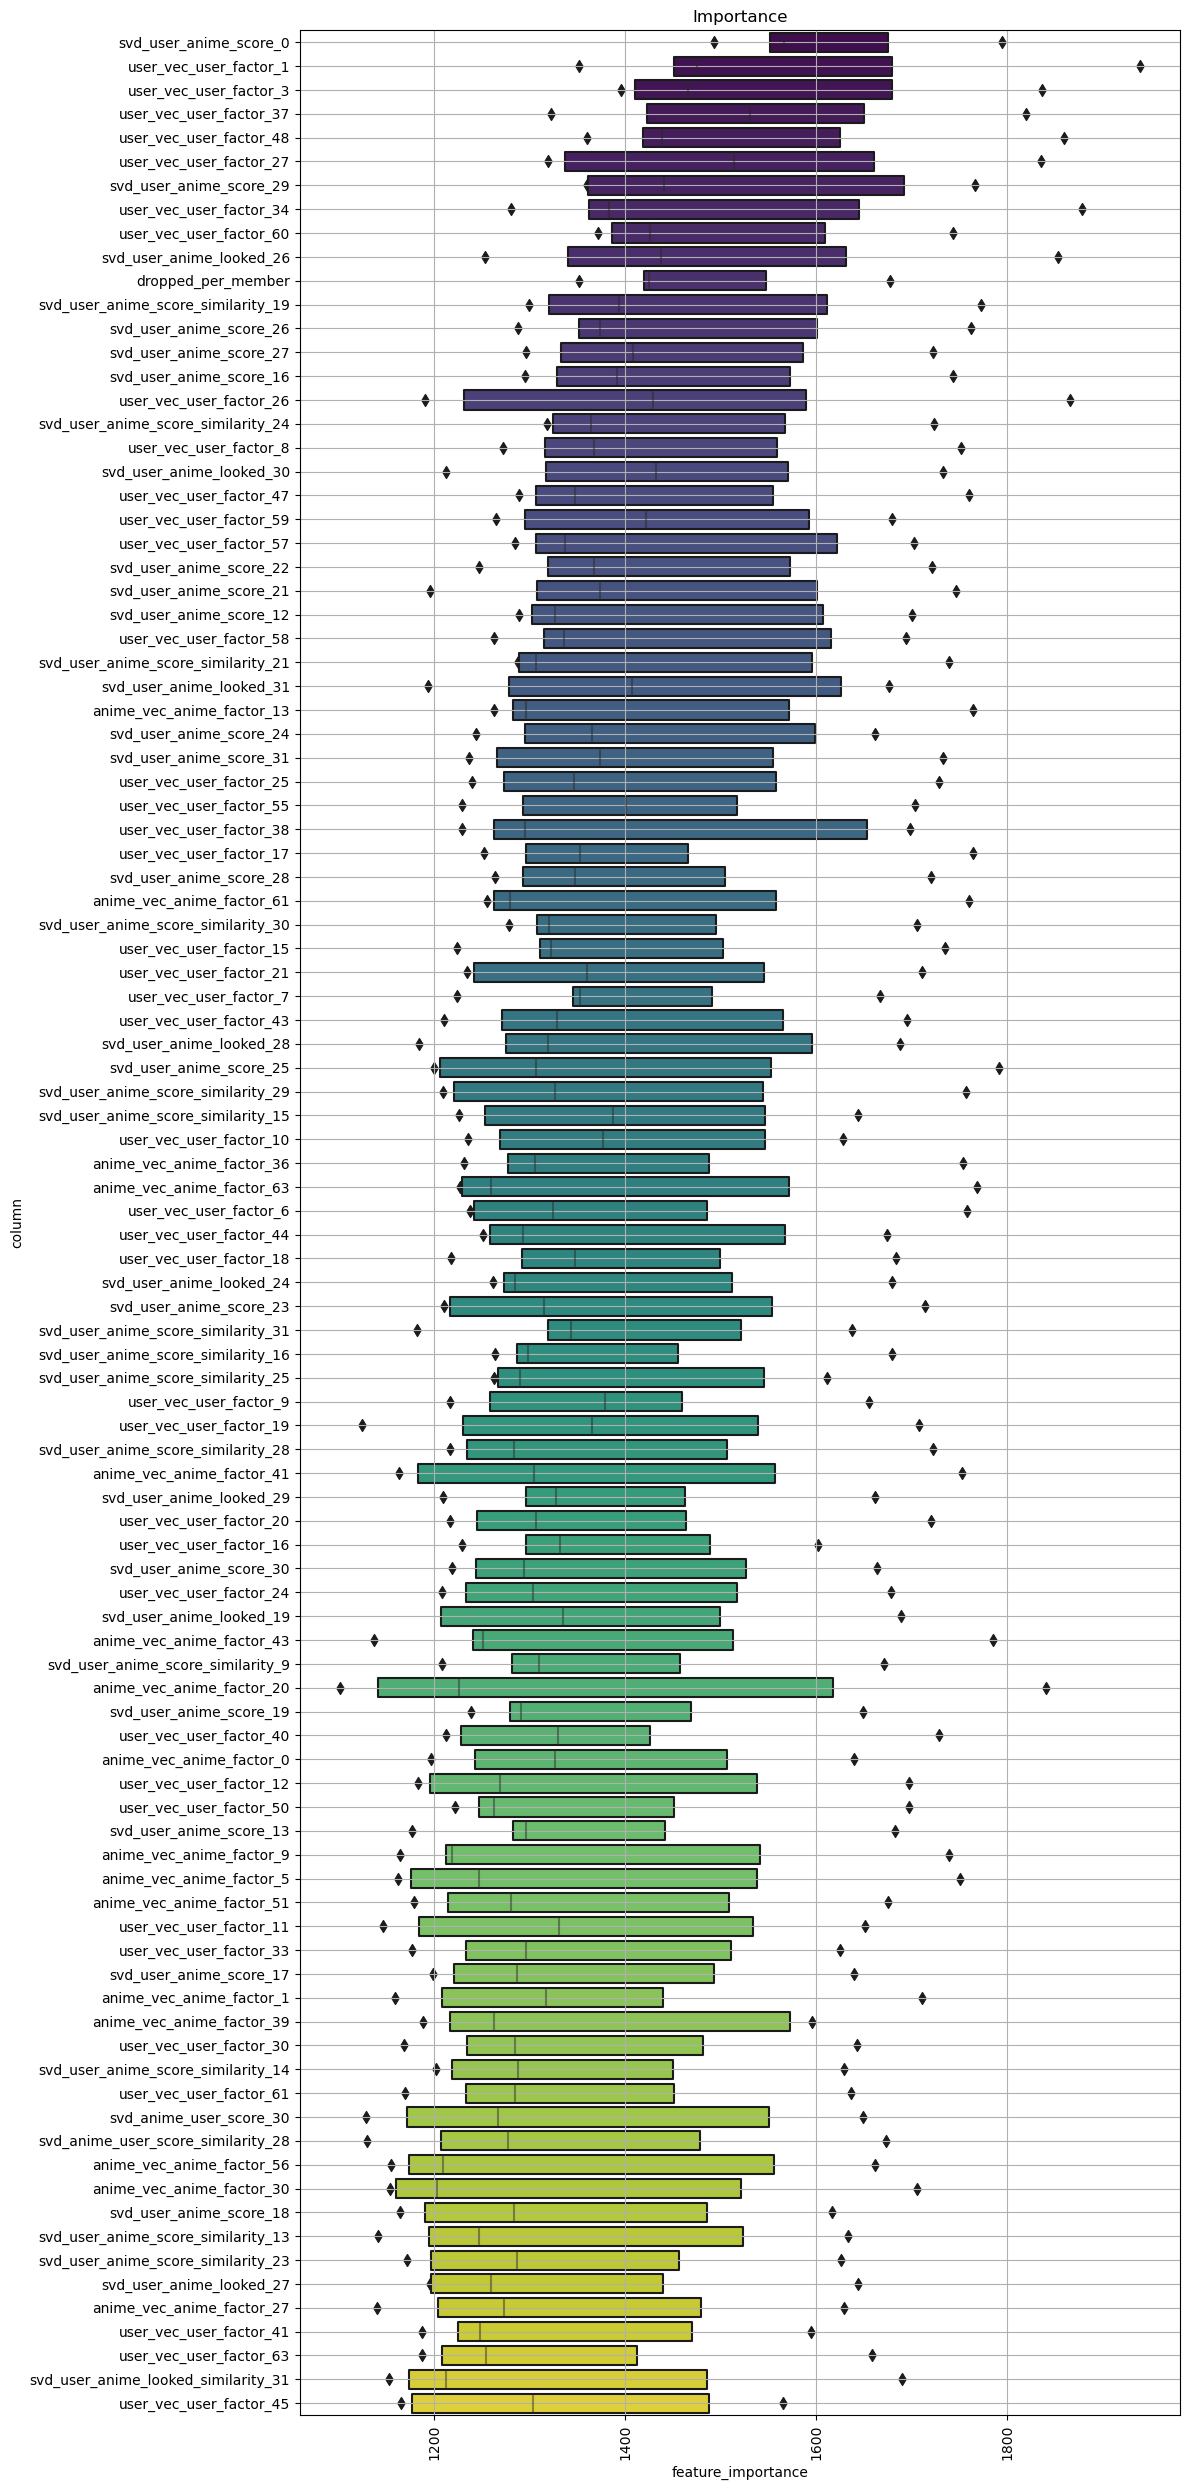

In [20]:
fig, ax = visualize_importance(models, x_tr_fold)

In [21]:
def _visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=True).index[:100]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

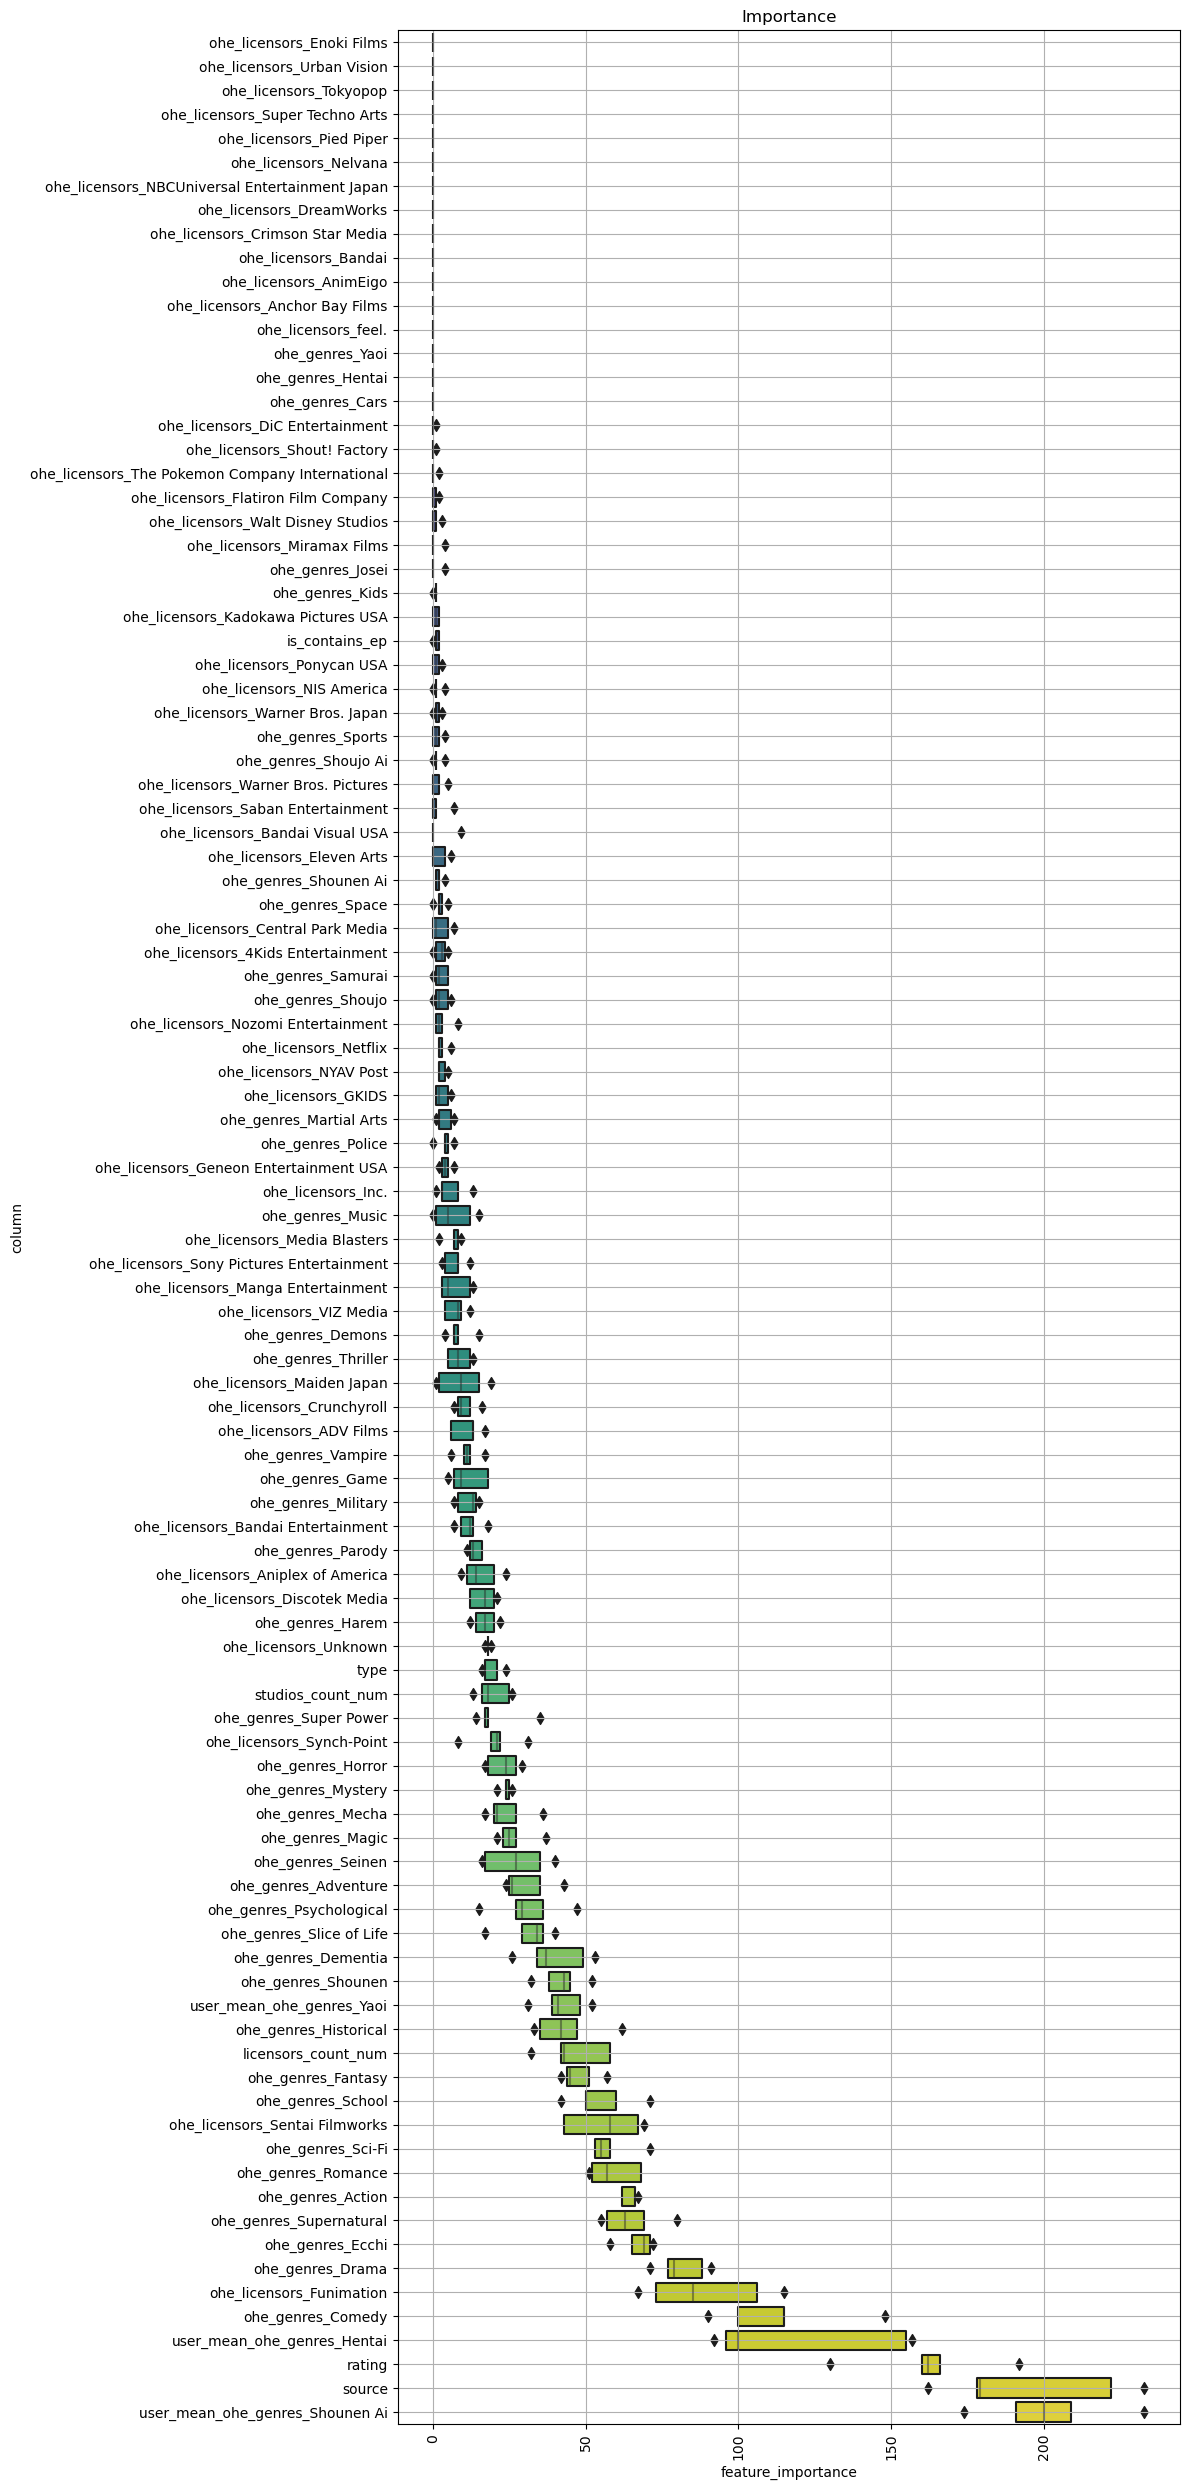

In [22]:
fig, ax = _visualize_importance(models, x_tr_fold)

# UnSeen_LGB

In [23]:
train_unseen_df = train_df.copy()
train_unseen_df = create_kfold_unseen(train_unseen_df)
test_unseen_df = test_df[~test_df["user_id"].isin(train_df["user_id"].unique())].reset_index(drop=True)

In [24]:
train_unseen_df[train_unseen_df["kfold"]==0]

,user_id,anime_id,score,genres,japanese_name,type,episodes,aired,producers,licensors,...,svd_anime_user_score_similarity_23,svd_anime_user_score_similarity_24,svd_anime_user_score_similarity_25,svd_anime_user_score_similarity_26,svd_anime_user_score_similarity_27,svd_anime_user_score_similarity_28,svd_anime_user_score_similarity_29,svd_anime_user_score_similarity_30,svd_anime_user_score_similarity_31,kfold
41,001a7aed2546342e2602,034eb6feb083d80751a4,9,"Drama, School, Shounen, Slice of Life",ランウェイで笑って,5,12.0,"Jan 11, 2020 to Mar 28, 2020","Mainichi Broadcasting System, Kodansha, DMM pi...",Funimation,...,-0.041888,0.407140,-0.158803,0.090111,0.063658,-0.004549,-0.250331,-0.239573,-0.158427,0
42,001a7aed2546342e2602,04068820a73e52dc3b32,9,"Action, Comedy, Slice of Life, Supernatural",モブサイコ100 II,5,13.0,"Jan 7, 2019 to Apr 1, 2019","Warner Bros. Japan, KlockWorx, BS Fuji, Hakuho...",Funimation,...,-0.038664,-0.079385,0.134679,0.123696,0.060202,0.056918,-0.074294,0.024312,-0.033532,0
43,001a7aed2546342e2602,057c8610088179f68964,9,"Comedy, Drama, School, Shounen, Sports",ハイキュー!!,5,25.0,"Apr 6, 2014 to Sep 21, 2014","Mainichi Broadcasting System, TOHO animation, ...",Sentai Filmworks,...,0.037933,0.099953,-0.001090,0.104171,0.227362,0.110055,-0.060022,-0.019960,0.011696,0
44,001a7aed2546342e2602,08aaefd0726338c6cda6,8,"Comedy, Slice of Life",ばらかもん,5,12.0,"Jul 6, 2014 to Sep 28, 2014","VAP, Nippon Television Network",Funimation,...,0.078322,0.009947,0.098841,-0.205172,0.046641,0.050289,-0.064840,-0.072899,0.061711,0
45,001a7aed2546342e2602,09d9688ffb425b3903b2,8,"Comedy, Romance, School, Shounen",山田くんと7人の魔女 OAD,3,2.0,"Dec 17, 2014 to May 15, 2015",Kodansha,Unknown,...,-0.006362,0.014152,-0.046276,0.032150,-0.041474,0.053683,-0.089318,-0.019083,0.100527,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136396,ffa6ff8006f8630f3d11,e9ba5ca32ea7e22e0a55,6,"Comedy, Parody, Romance, School, Shounen",瀬戸の花嫁,5,26.0,"Apr 2, 2007 to Oct 1, 2007","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,...,0.050107,-0.048092,0.065265,-0.070692,-0.147060,0.202430,-0.144175,0.157419,0.081822,0
136397,ffa6ff8006f8630f3d11,ea2be994d7e36d2a720a,7,"Comedy, School, Shounen, Slice of Life, Supern...",斉木楠雄のΨ難,5,120.0,"Jul 4, 2016 to Dec 26, 2016","TV Tokyo, Shogakukan-Shueisha Productions, Pon...",Funimation,...,0.057107,0.015354,0.044400,-0.028173,-0.017248,0.171608,0.102324,-0.076326,-0.035428,0
136398,ffa6ff8006f8630f3d11,ee3804a55e2b4ad58aad,7,"Comedy, Shounen, Slice of Life",侵略!イカ娘,5,12.0,"Oct 5, 2010 to Dec 21, 2010","TV Tokyo, Lantis, Pony Canyon, Studio Jack","Media Blasters, Sentai Filmworks",...,0.125914,-0.053258,-0.075770,-0.125040,0.090335,0.022862,0.126701,0.089213,0.040087,0
136399,ffa6ff8006f8630f3d11,fc143f3fa9979ab1c230,9,"Horror, Mystery, Psychological, Sci-Fi, Shoune...",約束のネバーランド,5,12.0,"Jan 10, 2019 to Mar 29, 2019","Aniplex, Dentsu, A-1 Pictures, Fuji TV, Shueis...",Aniplex of America,...,0.017756,0.088880,0.039307,0.251828,0.105084,-0.051106,-0.034618,0.002287,-0.061216,0


In [25]:
null_col = test_unseen_df.isnull().sum()[test_unseen_df.isnull().sum()>len(test_unseen_df)/10].index.tolist()

drop_col = ["user_id", "anime_id", "japanese_name", "genres", "producers", 
            "licensors", "studios", "aired", "score", "kfold", "user_score_var", "user_score_median", "user_score_mean"]

drop_col = drop_col + null_col

In [26]:
oof_df2 = pd.DataFrame()
models = []
lgb_test_preds2 = []
for fold in range(5):
    print(f"*****fold:{fold}******")
    train_data = train_unseen_df[train_unseen_df["kfold"]!=fold].reset_index(drop=True)
    valid_data = train_unseen_df[train_unseen_df["kfold"]==fold].reset_index(drop=True)
    
    feature_cols = [col for col in train_data.columns if col not in drop_col]
    x_tr_fold = train_data[feature_cols]
    y_tr_fold = train_data["score"]
    x_vl_fold = valid_data[feature_cols]
    y_vl_fold = valid_data["score"]

    
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        x_tr_fold, y_tr_fold,
        eval_set=(x_vl_fold, y_vl_fold),
        eval_metric="rmse",
        verbose=200,
        early_stopping_rounds=100,
    )

    models.append(model)

    y_pred = model.predict(x_vl_fold)    
    score = np.sqrt(mean_squared_error(y_vl_fold.values, y_pred))
    print(f"*****valid_score:{score}******")
    valid_data["lgb_pred"] = y_pred
    oof_df2 = pd.concat([oof_df2, valid_data])
    lgb_test_preds2.append(model.predict(test_unseen_df[feature_cols]))

*****fold:0******
[LightGBM] [Warning] lambda_l1 is set=1.0712614649751512e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0712614649751512e-08
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.5532335723253327e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5532335723253327e-08
[LightGBM] [Warning] feature_fraction is set=0.652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[200]	valid_0's rmse: 1.34365
[400]	valid_0's rmse: 1.34053
*****valid_score:1.3399979054920337******
*****fold:1******
[LightGBM] [Warning] lambda_l1 is set=1.0712614649751512e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0712614649751512e-08
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Curr

In [27]:
unseen_score = np.sqrt(mean_squared_error(oof_df2["score"].values, oof_df2["lgb_pred"].values))
print(seen_score, unseen_score)
all_score = np.sqrt(0.77*seen_score**2 + 0.23*unseen_score**2)
print(f"########{all_score}#######")

1.1045808172861546 1.3770077331749413
########1.1728557585812371#######


In [28]:
oof_df2[["user_id", "anime_id", "score", "lgb_pred"]].to_csv("lgb_unseen_oof_df.csv", index=False)

In [29]:
test_seen_df["pred"] = np.mean(lgb_test_preds, axis=0)
test_unseen_df["pred"] = np.mean(lgb_test_preds2, axis=0)
final_test_df = pd.concat([test_seen_df, test_unseen_df]).reset_index(drop=True)
_test_df = test_df.merge(final_test_df[["user_id", "anime_id", "pred"]], on=["user_id", "anime_id"], how="left")
_test_df["pred2"] = _test_df['pred'].apply(lambda x: np.clip(x, 1, 10))

sub = pd.read_csv("/kaggle/input/atmacup-15dataset/sample_submission.csv")
sub["score"] = _test_df["pred2"]
sub.to_csv("seen_split_submission_20230723_02.csv", index=False)

In [30]:
#CV:1.2026951053806554 score特徴量あり

#CV:1.2106212434814234 leakなし

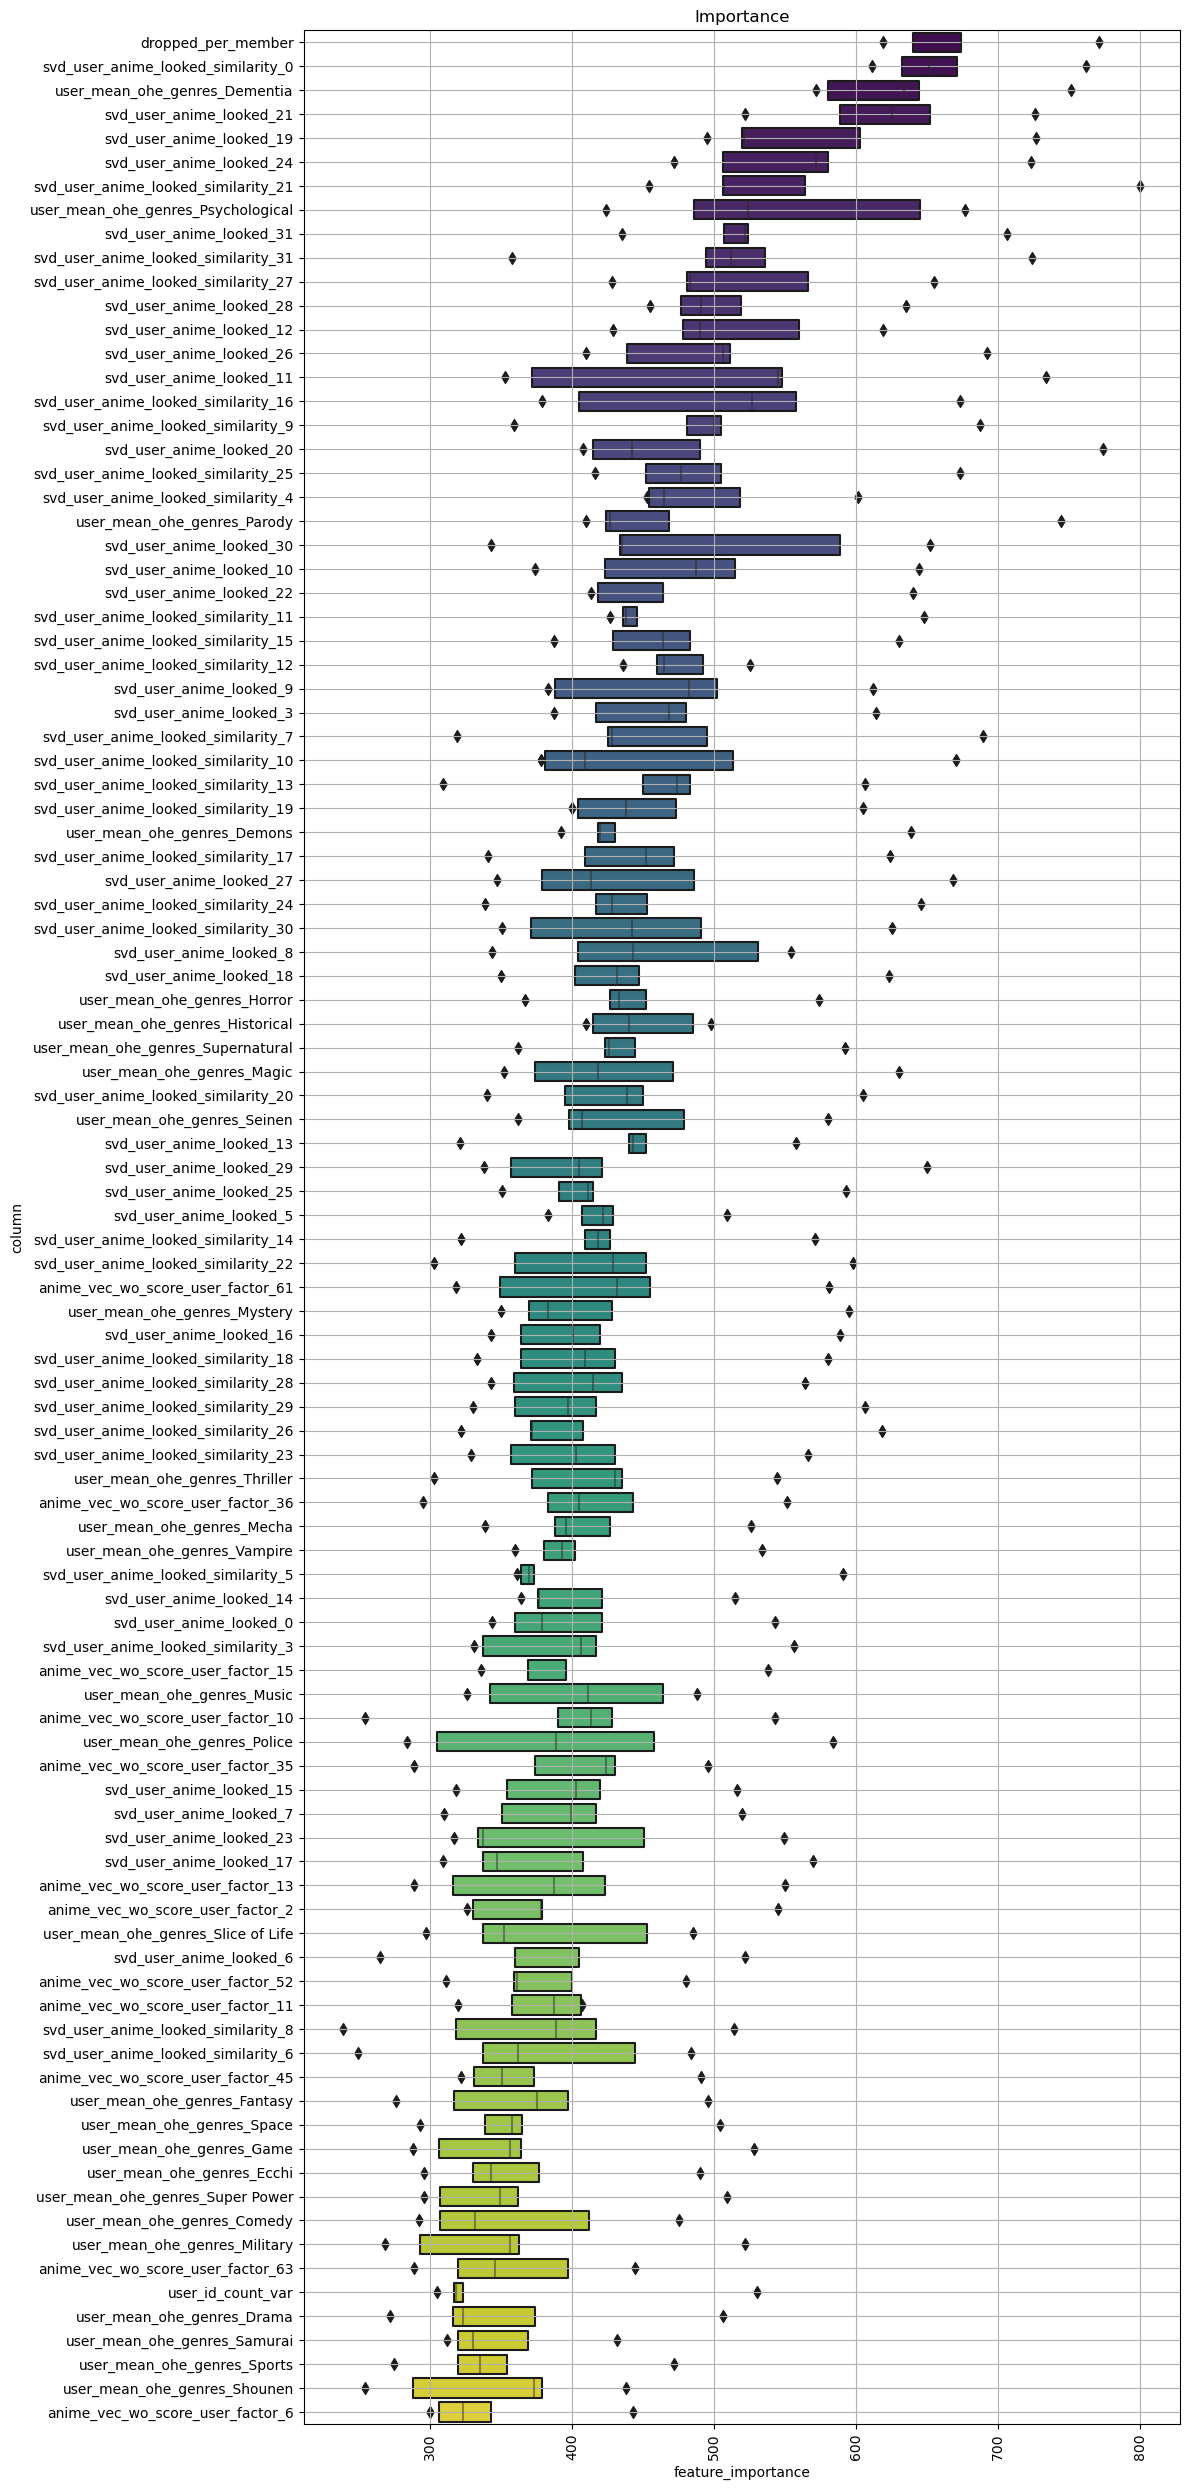

In [31]:
fig, ax = visualize_importance(models, x_tr_fold)

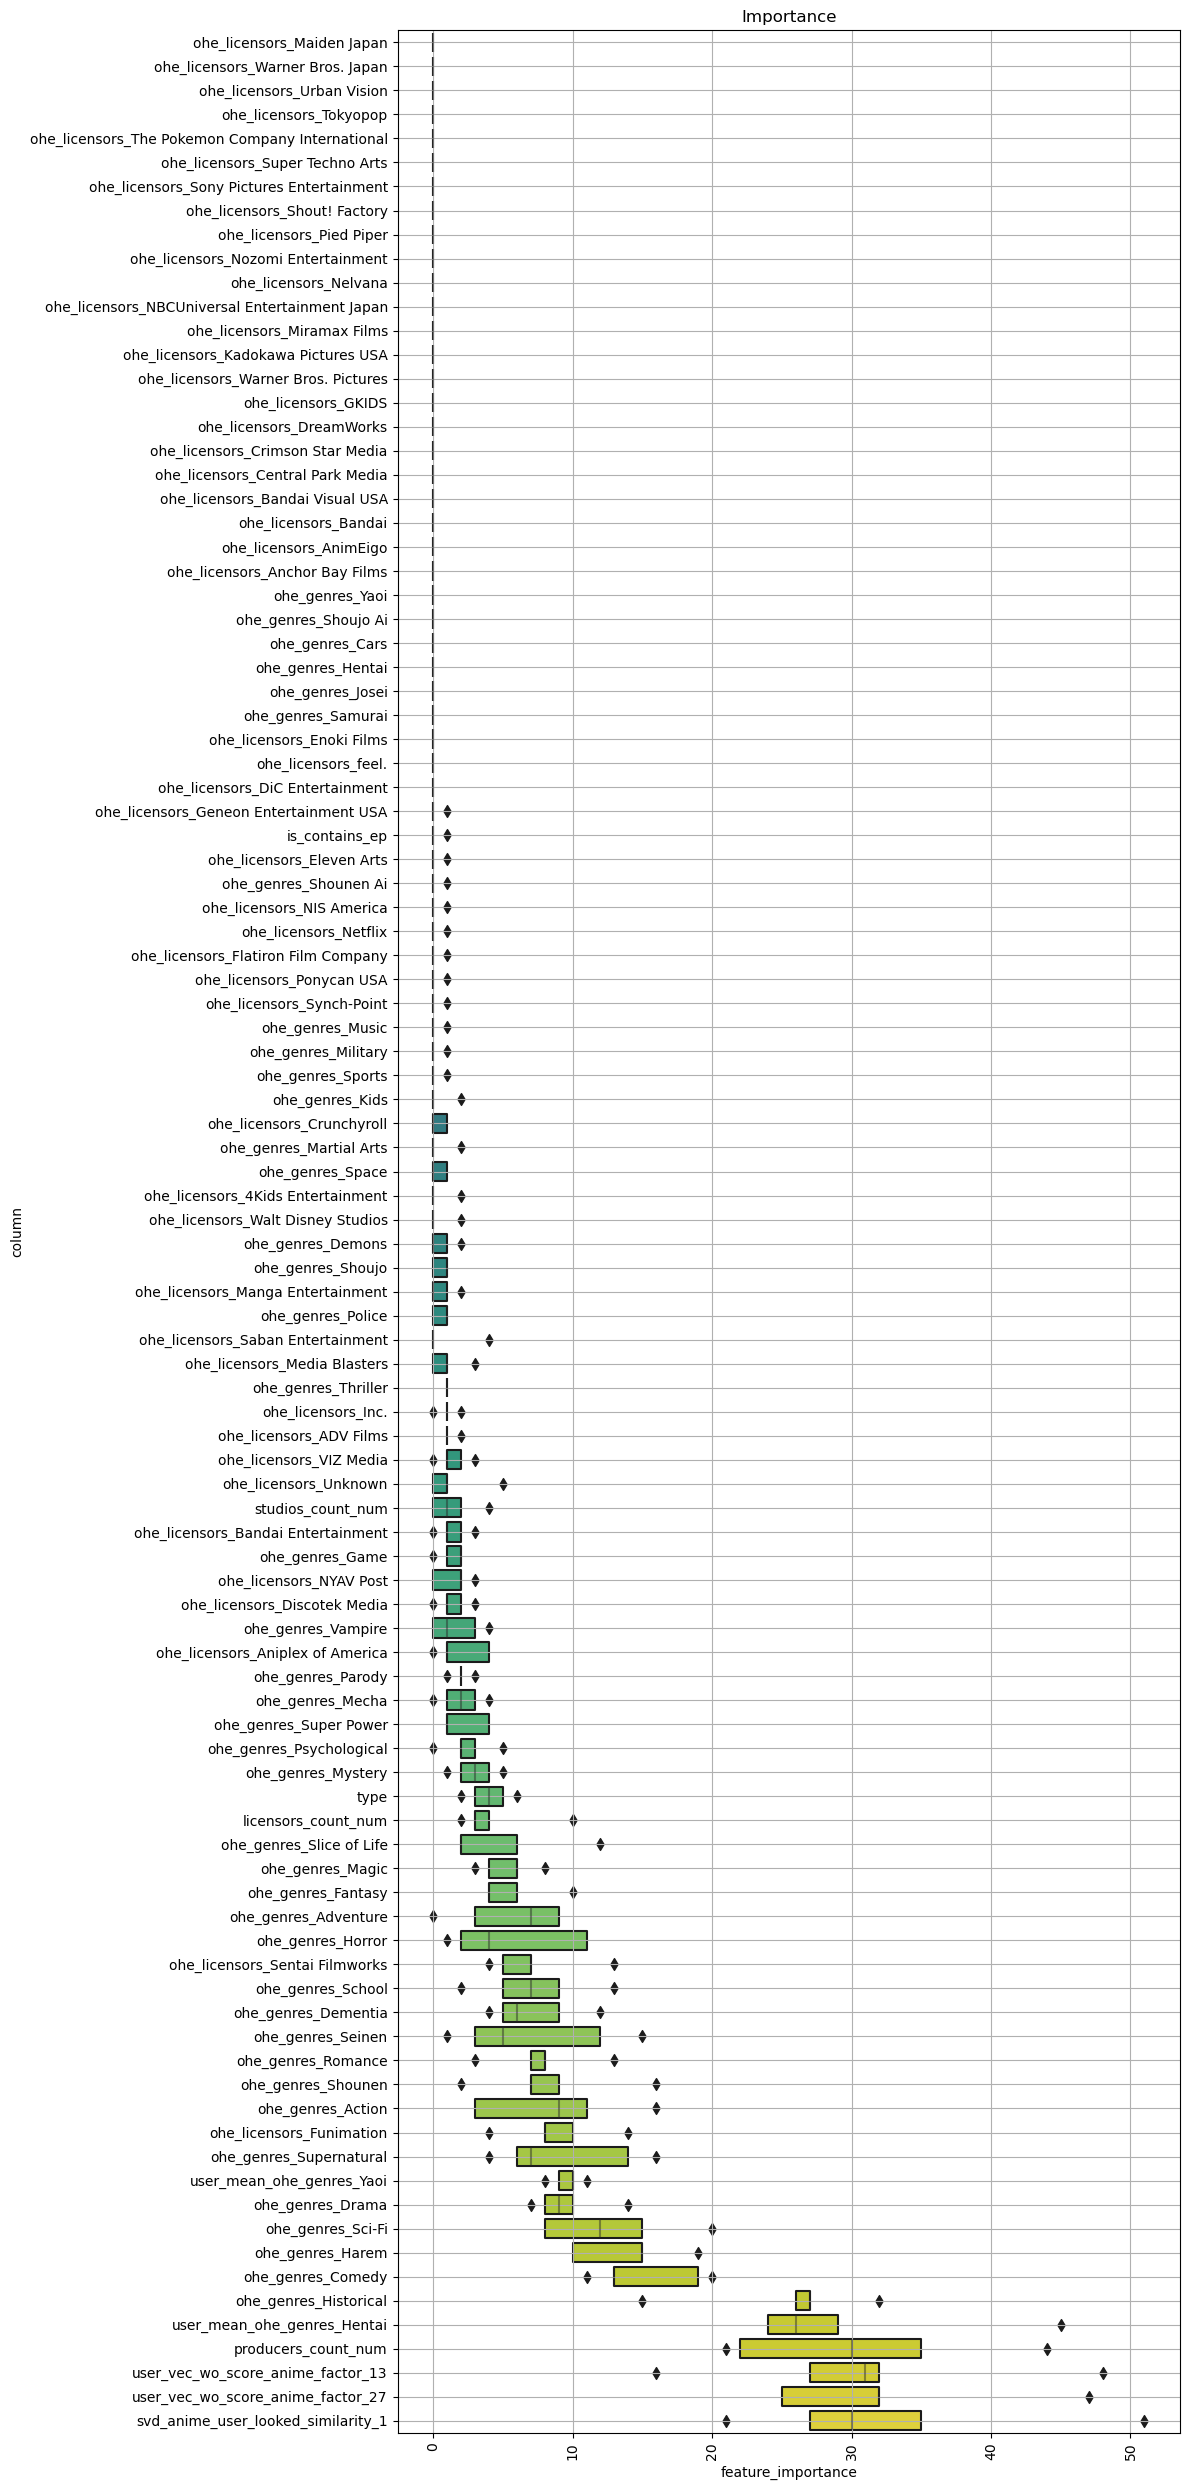

In [32]:
fig, ax = _visualize_importance(models, x_tr_fold)

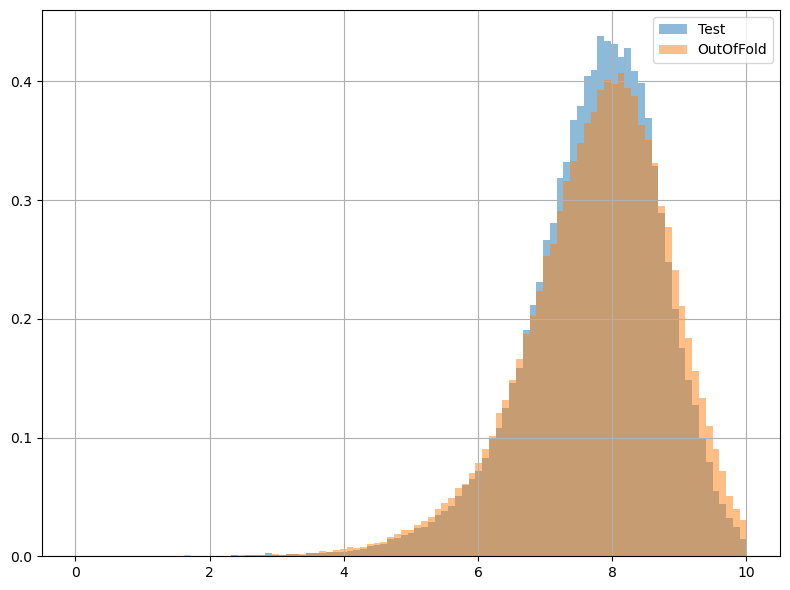

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(final_test_df["pred"], bins=bins, density=True, alpha=.5, label="Test")
ax.hist(oof_df["lgb_pred"], bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()